<center><h2>ALTeGraD 2022<br>Lab Session 2: Transfer learning for NLP</h2> 27 / 10 / 2022<br> M. Kamal Eddine, H. Abdine<br><br>


<b>Student name:</b> Sicheng MAO

</center>

<br><br>
In this lab we will:
* Implement and pretrain a language model with transformer architecture.
* Use the pretrained model (transfer learning) to perform a sentiment analysis task which consists of classifying some books reviews into positive and negative ones.
* Compare the performance of the pretrained model to a model trained from scratch.
 <br>
 
<b>The deadline for this lab is November 14, 2022 11:59 PM.</b> More details about the submission and the architecture for this lab can be found in the handout PDF.

In [1]:
import math

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### The Model

In [2]:
class TransformerModel(nn.Module):
    def __init__(self, ntoken, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        '''
        ntokens: the size of vocabulary
        nhid: the hidden dimension of the model.
        We assume that embedding_dim = nhid
        nlayers: the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
        nhead: the number of heads in the multiheadattention models
        dropout: the dropout value
         '''
        self.model_type = "Transformer"
        self.encoder = nn.Embedding(num_embeddings = ntoken, embedding_dim = nhid) # fill me, nhid = the dim_embed
        self.pos_encoder = PositionalEncoding(nhid=nhid) #fill me, the PositionalEncoding class is implemented in the next cell
        encoder_layers = nn.TransformerEncoderLayer(d_model = nhid, nhead = nhead, dim_feedforward = nhid, dropout = dropout) #fill me we assume nhid = d_model = dim_feedforward
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers = nlayers) #fill me
        self.nhid = nhid
        self.init_weights()

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = (
            mask.float()
            .masked_fill(mask == 0, float("-inf"))
            .masked_fill(mask == 1, float(0.0))
        )
        return mask

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, src_mask):
        '''
        Args:
            src: Tensor, shape [seq_len, batch_size]
            src_mask: Tensor, shape [seq_len, seq_len]

        Returns:
            output Tensor of shape [seq_len, batch_size, ntoken]
        '''
        src = self.encoder(src) * math.sqrt(self.nhid)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_mask)
        return output


class ClassificationHead(nn.Module):
    def __init__(self, nhid, nclasses):
        super(ClassificationHead, self).__init__()
        self.decoder = nn.Linear(nhid, nclasses)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        output = self.decoder(src)
        return output
    
class Model(nn.Module):
    def __init__(self, ntoken, nhead, nhid, nlayers, nclasses, dropout=0.5):
        super(Model, self).__init__()
        self.base = TransformerModel(ntoken, nhead, nhid, nlayers)
        self.classifier = ClassificationHead(nhid, nclasses)

    def forward(self, src, src_mask):
        # base model
        x = self.base(src, src_mask)
        # classifier model
        output = self.classifier(x)
        return output

In [3]:
class PositionalEncoding(nn.Module):
    def __init__(self, nhid, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, nhid)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, nhid, 2).float() * (-math.log(10000.0) / nhid)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[: x.size(0), :]
        return self.dropout(x)

Let's verify if our model works, by applying one inference step

In [4]:
ntokens = 100 # the size of vocabulary
nhid = 200  # hidden dimension
nlayers = 4  # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2  # the number of heads in the multiheadattention models
dropout = 0  # the dropout value

model = Model(ntokens, nhead, nhid, nlayers, ntokens, dropout).to(device)
dummy_input = torch.tensor([[2, 6, 2, 5, 43, 21]]).to(device)
src_mask = model.base.generate_square_subsequent_mask(1).to(device)
out = model.forward(dummy_input, src_mask)

print(out.shape) # is it the right shape?

torch.Size([1, 6, 100])


In [5]:
print(out[0][0])

tensor([ 0.7138, -0.1413,  0.2734,  2.4253, -0.5079,  0.2122, -1.4434, -0.4653,
        -0.9514,  1.6774, -0.7325,  1.0488,  0.9989,  1.5706,  0.7859,  0.1369,
         1.2027,  0.3692,  0.4479, -1.0119, -0.0792, -0.1049,  0.1175, -1.2617,
        -1.4365, -0.5686, -0.1960,  0.1295,  0.3498,  0.6875,  0.2201,  0.2695,
        -1.1672,  0.5189, -1.2647,  0.1727, -0.3303, -1.3664,  0.1682, -2.3528,
        -0.2755, -1.4338, -1.0979, -0.5085,  1.6198, -0.3388, -0.7955, -0.4648,
         0.0186,  0.0108, -0.8273,  0.5023,  0.0048, -0.4990,  0.2525,  0.0321,
        -0.5266, -0.7469, -0.4956,  0.3952,  1.4615,  0.0521, -0.7608,  1.1481,
        -0.3321, -0.7071,  0.3510, -0.8542, -0.6793, -0.4115,  0.1402, -0.8882,
        -0.3408,  1.0072, -0.4910, -0.2398, -0.0436, -1.2243,  2.0696,  2.5848,
        -0.6041,  1.0915, -0.4513,  0.4450,  0.0124, -0.7892, -0.5172,  1.3586,
         0.4681,  0.6004, -1.6136,  2.4900, -1.3775, -1.2326,  0.0569,  0.0483,
        -0.8962,  1.2532,  1.2661,  0.80

## Vocabulary and Tokenization

In [6]:
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/dict.txt
!head -5 dict.txt

--2022-11-05 09:06:49--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/dict.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 577587 (564K) [text/plain]
Saving to: 'dict.txt.1'

dict.txt.1          100%[===================>] 564.05K  --.-KB/s    in 0.05s   

2022-11-05 09:06:49 (11.8 MB/s) - 'dict.txt.1' saved [577587/577587]

▁d 1
es 1
▁l 1
en 1
on 1


In [7]:
path_vocab = "dict.txt"
token2ind = {"<sos>": 0, "<pad>": 1, "<eos>": 2, "<oov>": 3} # the 4 first indices are reserved to special tokens
with open(path_vocab, "r") as f:
    for idx, line in enumerate(f):
        word = line.split()[0].strip()
        token2ind[word] = idx + 4 #fill me

ind2token = {idx: word for (word, idx) in token2ind.items()} #fill me

print(ind2token[1111])

▁trop


### Data Loader


In [8]:
token2ind.get('=',3)

3

In [9]:
import numpy
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset


class Dataset(Dataset):
    def __init__(
        self,
        path_documents,
        path_labels=None,
        token2ind={},
        max_len=512,
        task="language_modeling",
    ):
        self.task = task
        self.max_len = max_len
        self.token2ind = token2ind
        self.documents = []
        self.labels = []
        with open(path_documents, "r") as f1:
            for line in f1:
                self.documents.append(line.strip())
        if task == "classification":
            with open(path_labels, "r") as f1:
                for line in f1:
                    self.labels.append(int(line.strip()))
            assert len(self.labels) == len(self.documents)

    def __len__(self):
        return len(self.documents)

    def __getitem__(self, index):
        sequence = self.documents[index].split()
        if len(sequence) > self.max_len - 1:
            sequence = sequence[: self.max_len - 1]
        # <oov> index is 3
        source_sequence =  [token2ind.get(token, 3) for token in sequence]#fill me (constract the input sequence using token2ind, sequence and special tokens)
        if self.task == "language_modeling":
            target = source_sequence[1:]
            target.append(self.token2ind["<eos>"])
        elif self.task == "classification":
            target = [self.labels[index]]
        sample = {
            "source_sequence": torch.tensor(source_sequence),
            "target": torch.tensor(target),
        }
        return sample


def MyCollator(batch):
    source_sequences = pad_sequence(
        #we use padding to match the length of the sequences in the same batch
        [sample["source_sequence"] for sample in batch], padding_value=token2ind["<pad>"]
    )
    target = pad_sequence(
        [sample["target"] for sample in batch], padding_value=token2ind["<pad>"]
    )
    return source_sequences, target.reshape(-1)


def get_loader(
    path_documents,
    path_labels=None,
    token2ind={},
    max_len=512,
    batch_size=32,
    task="language_modeling",
):
    dataset = Dataset(
        path_documents,
        path_labels=path_labels,
        token2ind=token2ind,
        max_len=512,
        task=task,
    )
    data_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=MyCollator,
        pin_memory=True,
        drop_last=True,
    )
    return data_loader

## The Training

In [10]:
from tqdm import tqdm

In [11]:
def train(
    path_data_train,
    path_labels_train=None,
    path_data_valid=None,
    save_interval=-1,
    log_interval=5,
    task="language_modeling",
    batch_size=32,
):
    model.train()
    total_loss = 0.0
    ntokens = len(token2ind)
    data_loader = get_loader(
        path_data_train,
        path_labels_train,
        token2ind,
        task=task,
        batch_size=batch_size,
    )
    losses = []
    
    for idx, data in tqdm(enumerate(data_loader), total=len(data_loader)): #step 1
        optimizer.zero_grad()
        src_mask = model.base.generate_square_subsequent_mask(data[0].size(0)).to(device)
        # avoid using input since it is a built-in function
        input_data = data[0].to(device)
        # print(input_data.shape)
        output = model(input_data, src_mask) #step 2
        # print(output.shape)
        if task == 'classification':
            #last vector only, is the distribution on two classes
            output = output[-1,:]
            pass
        output = output.view(-1, output.shape[-1])
        # print(output)
        target = data[1] #fill me
        # print(target)
        target = target.to(device)
        loss = criterion(output, target) #fill me, Cross entropy check next cells
        #fill me step 3
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5) # prevent exploding gradient 
        #fill me step 4
        optimizer.step()
        total_loss += loss.item() 
        if idx % log_interval == 0 and idx > 0:
            cur_loss = total_loss / log_interval
            print(
                "| epoch {:3d} | {:5d}/{:5d} steps | "
                "loss {:5.5f} | ppl {:8.3f}".format(
                    epoch, idx, len(data_loader), cur_loss, math.exp(cur_loss),
                )
            )
            losses.append(cur_loss)
            total_loss = 0
    return losses

In [12]:
ntokens = len(token2ind) #fill me # the size of vocabulary
nhid = 200  # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 4  # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2  # the number of heads in the multiheadattention models
dropout = 0  # the dropout value

nclasses = 2 # for classification task only

#notice here that the nclasses argument = ntokens (for language modeling task, we predict the next token)
model = Model(ntokens, nhead, nhid, nlayers, ntokens, dropout).to(device)

In [13]:
# optimization paramerters

criterion = nn.CrossEntropyLoss(ignore_index=token2ind['<pad>'])
lr = 0.0003  # learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [14]:
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/pretraining_subset.txt
path_data_train = "pretraining_subset.txt"

--2022-11-05 09:06:50--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/pretraining_subset.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10146460 (9.7M) [text/plain]
Saving to: 'pretraining_subset.txt.1'

pretraining_subset. 100%[===================>]   9.68M  --.-KB/s    in 0.1s    

2022-11-05 09:06:50 (94.3 MB/s) - 'pretraining_subset.txt.1' saved [10146460/10146460]



In [15]:
len(token2ind)

50001

In [16]:
#pretraining on a tiny subset
log_interval = 500
epochs = 2
for epoch in range(1, epochs + 1): #5
    train(
        path_data_train,
        save_interval=-1,
        task='language_modeling', # fill me
        batch_size=16,
        log_interval=log_interval,
    )

 16%|█▌        | 502/3125 [00:24<01:56, 22.49it/s]

| epoch   1 |   500/ 3125 steps | loss 7.59751 | ppl 1993.231


 32%|███▏      | 1003/3125 [00:50<01:41, 20.83it/s]

| epoch   1 |  1000/ 3125 steps | loss 6.85649 | ppl  950.026


 48%|████▊     | 1502/3125 [01:15<01:21, 19.95it/s]

| epoch   1 |  1500/ 3125 steps | loss 6.54952 | ppl  698.906


 64%|██████▍   | 2002/3125 [01:40<00:50, 22.29it/s]

| epoch   1 |  2000/ 3125 steps | loss 6.37271 | ppl  585.644


 80%|████████  | 2503/3125 [02:06<00:35, 17.54it/s]

| epoch   1 |  2500/ 3125 steps | loss 6.22746 | ppl  506.466


 96%|█████████▌| 3005/3125 [02:33<00:05, 22.04it/s]

| epoch   1 |  3000/ 3125 steps | loss 6.15350 | ppl  470.361


 16%|█▌        | 503/3125 [00:25<02:02, 21.32it/s]

| epoch   2 |   500/ 3125 steps | loss 5.85538 | ppl  349.108


 32%|███▏      | 1005/3125 [00:51<01:40, 21.11it/s]

| epoch   2 |  1000/ 3125 steps | loss 5.79816 | ppl  329.692


 48%|████▊     | 1506/3125 [01:18<01:16, 21.13it/s]

| epoch   2 |  1500/ 3125 steps | loss 5.76633 | ppl  319.365


 64%|██████▍   | 2003/3125 [01:44<01:02, 17.89it/s]

| epoch   2 |  2000/ 3125 steps | loss 5.68995 | ppl  295.880


 80%|████████  | 2505/3125 [02:10<00:30, 20.31it/s]

| epoch   2 |  2500/ 3125 steps | loss 5.66414 | ppl  288.340


 96%|█████████▌| 3004/3125 [02:37<00:06, 18.89it/s]

| epoch   2 |  3000/ 3125 steps | loss 5.64214 | ppl  282.066


100%|██████████| 3125/3125 [02:44<00:00, 19.03it/s]


In [17]:
print(model)

Model(
  (base): TransformerModel(
    (encoder): Embedding(50001, 200)
    (pos_encoder): PositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=200, out_features=200, bias=True)
          )
          (linear1): Linear(in_features=200, out_features=200, bias=True)
          (dropout): Dropout(p=0.5, inplace=False)
          (linear2): Linear(in_features=200, out_features=200, bias=True)
          (norm1): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.5, inplace=False)
          (dropout2): Dropout(p=0.5, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in

In [18]:
50001 * 200

10000200

In [19]:
for name, param in model.named_parameters():
  print(name, param.size(), param.requires_grad)

base.encoder.weight torch.Size([50001, 200]) True
base.transformer_encoder.layers.0.self_attn.in_proj_weight torch.Size([600, 200]) True
base.transformer_encoder.layers.0.self_attn.in_proj_bias torch.Size([600]) True
base.transformer_encoder.layers.0.self_attn.out_proj.weight torch.Size([200, 200]) True
base.transformer_encoder.layers.0.self_attn.out_proj.bias torch.Size([200]) True
base.transformer_encoder.layers.0.linear1.weight torch.Size([200, 200]) True
base.transformer_encoder.layers.0.linear1.bias torch.Size([200]) True
base.transformer_encoder.layers.0.linear2.weight torch.Size([200, 200]) True
base.transformer_encoder.layers.0.linear2.bias torch.Size([200]) True
base.transformer_encoder.layers.0.norm1.weight torch.Size([200]) True
base.transformer_encoder.layers.0.norm1.bias torch.Size([200]) True
base.transformer_encoder.layers.0.norm2.weight torch.Size([200]) True
base.transformer_encoder.layers.0.norm2.bias torch.Size([200]) True
base.transformer_encoder.layers.1.self_attn.

## Text Generation


In [20]:
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/pretrained_model_4layers.pt

--2022-11-05 09:12:14--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/pretrained_model_4layers.pt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88093955 (84M) [application/octet-stream]
Saving to: 'pretrained_model_4layers.pt.1'

pretrained_model_4l 100%[===================>]  84.01M   195MB/s    in 0.4s    

2022-11-05 09:12:15 (195 MB/s) - 'pretrained_model_4layers.pt.1' saved [88093955/88093955]



In [21]:
model = Model(ntokens, nhead, nhid, nlayers, ntokens).to(device) 

#load the checkpoint
checkpoint = torch.load('pretrained_model_4layers.pt', map_location=device)
#load state dict
model.load_state_dict(checkpoint['model_state_dict']) 

<All keys matched successfully>

In [22]:
!pip install sentencepiece   # uncomment this if you are using google colab

!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/sentencepiece.french.model

import sentencepiece as spm

s = spm.SentencePieceProcessor(model_file='sentencepiece.french.model') #load sentencepiece model

#examples
encoded = s.encode_as_pieces("Bonjour les amis!")
decoded = s.decode_pieces(encoded)
print(encoded)
print(decoded)

--2022-11-05 09:12:18--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/sentencepiece.french.model
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115362 (1.1M) [application/octet-stream]
Saving to: 'sentencepiece.french.model.1'

sentencepiece.frenc 100%[===================>]   1.06M  --.-KB/s    in 0.06s   

2022-11-05 09:12:18 (17.8 MB/s) - 'sentencepiece.french.model.1' saved [1115362/1115362]

['▁Bonjour', '▁les', '▁amis', '!']
Bonjour les amis!


In [23]:
def infer_next_token(sent):
    model.eval()
    sent_pieces = s.encode_as_pieces(sent)
    source = [token2ind['<sos>']] + [token2ind[el] for el in sent_pieces] # list of tokens
    source = torch.tensor(source).to(device)
    source = source.reshape(-1, 1)
    src_mask = model.base.generate_square_subsequent_mask(source.size(0)).to(device)
    out = model(source, src_mask)
    next_token_ind = out[-1].squeeze().argmax().item() # the last hidden state
    return next_token_ind, out

def infer_next_tokens(sent, max_len=50):
    # to be implemented
    tokens = s.encode_as_pieces(sent)
    sent_gen = sent  # sent is a normal sentence
    for i in range(max_len):
        next_token_ind, _ = infer_next_token(sent_gen)
        cur_token = ind2token[next_token_ind]
        if cur_token == '<eos>':
            break
        else:
            tokens.append(cur_token)
            sent_gen = s.decode_pieces(tokens)
    
    return sent_gen

In [24]:
sent = "Bonjour les"

In [25]:
ind, out = infer_next_token(sent)
print(ind)

1696


The output 

In [26]:
out.shape

torch.Size([3, 1, 50001])

In [27]:
out = out.argmax(axis = 2).squeeze().tolist()

In [28]:
for ind in out:
    token = ind2token[ind]
    print(token)

▁Il
,
▁gens


In [29]:
s.decode_pieces(token)

'gens'

In [30]:
token2ind[token]

1696

It means given `<sos>` the next token is `Il`,
given `<sos> Bonjour` the next token is `,`,
given `<sos> Bonjour les` the next token is `gens`.

In [31]:
infer_next_tokens(sent)

'Bonjour les gens qui ont été très accueillants et sympathiques.'

Loop seems strange

In [32]:
infer_next_tokens("Je t'aime")

"Je t'aime bien les gens qui ont des gens qui ont des gens qui ont des gens qui ont des gens qui ont des gens qui ont des gens qui ont des gens qui ont des gens qui ont des gens qui ont des gens qui ont des gens qui ont des"

Ok Artificial Ignorance...

In [33]:
infer_next_tokens("Bien les gens ont des gens qui ont des gens")

'Bien les gens ont des gens qui ont des gens qui ont des gens qui ont des gens qui ont des gens qui ont des gens qui ont des gens qui ont des gens qui ont des gens qui ont des gens qui ont des gens qui ont des gens qui ont des gens qui ont des gens qui ont'

### Supervised task

In [34]:
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/train.review.spm
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/train.label
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/test.review.spm
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/test.label

path_data_train = "train.review.spm"
path_labels_train = "train.label"

path_data_valid = "test.review.spm"
path_labels_valid = "test.label"

--2022-11-05 09:12:19--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/train.review.spm
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1495960 (1.4M) [text/plain]
Saving to: 'train.review.spm.1'

train.review.spm.1  100%[===================>]   1.43M  --.-KB/s    in 0.06s   

2022-11-05 09:12:19 (22.3 MB/s) - 'train.review.spm.1' saved [1495960/1495960]

--2022-11-05 09:12:19--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/train.label
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request s

In [35]:
# a function to evaluate the validation accuracy of the model.
# adapt from lab1 and train()
def evaluate_accuracy(data_loader):
    #to be implemented
    model.eval()
    # total_loss = 0.0
    ncorrect = ntotal = 0
    with torch.no_grad():
        for idx, data in tqdm(enumerate(data_loader),total=len(data_loader)):
            src_mask = model.base.generate_square_subsequent_mask(data[0].size(0)).to(device)
            # inference
            input_data = data[0].to(device)
            output = model(input_data, src_mask)
            #last vector only, is the distribution on two classes
            output = output[-1,:]
            output = output.view(-1, output.shape[-1])
            prediction = output.argmax(axis=-1)
            # print(output)
            target = data[1].to(device)
            # total number of examples
            ntotal += output.shape[0]
            # number of correct predictions
            ncorrect += torch.sum(target == prediction)  # number of correct prediction - hint: use torch.sum 
        acc = ncorrect.item() / ntotal
        return acc

In [36]:
#save the base model to be loaded later in the fine-tuning phase
torch.save({"model_state_dict": model.base.state_dict(),}, "pretrained_model_4layers_no_class_head.pt")

In [37]:
o = torch.tensor([[-1.1873, -0.4178],
        [-0.3639, -1.1610],
        [-0.7206,  0.4625],
        [-0.9607,  0.4202],
        [-1.6203,  0.6857],
        [ 0.2038, -0.8536],
        [-0.0487, -0.6102],
        [-0.2580,  0.0405]])
t = torch.tensor([0, 0, 0, 1, 0, 1, 1, 1])

In [38]:
criterion(o,t)

tensor(1.3434)

In [39]:
from_scratch_settings = [True, False]

from_scratch_valid_acc = []
pretrained_valid_acc = []
lr = 0.0001

for from_scratch in from_scratch_settings:
    model = Model(ntokens, nhead, nhid, nlayers, 2, dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    if not from_scratch:
        print("=====PRETRAINED MODEL======")
        #load checkpoint
        checkpoint = torch.load("pretrained_model_4layers_no_class_head.pt")
        #load state dict
        model.base.load_state_dict(checkpoint['model_state_dict'])
    else:
        print("=====Trainig FROM SCRATCH======")
    epochs = 15
    for epoch in range(1, epochs + 1):
        train(
            path_data_train,
            path_labels_train,
            save_interval=-1,
            task='classification',
            batch_size=8,
            log_interval=50,
        )
        acc = evaluate_accuracy(
            get_loader(
                path_data_valid,
                path_labels_valid,
                token2ind=token2ind,
                batch_size=20,
                task='classification',
            )
        )
        if from_scratch:
            from_scratch_valid_acc.append(acc)
        else:
            pretrained_valid_acc.append(acc)
    print()

=====Trainig FROM SCRATCH======


 28%|██▊       | 57/200 [00:01<00:03, 39.19it/s]

| epoch   1 |    50/  200 steps | loss 0.81389 | ppl    2.257


 55%|█████▌    | 110/200 [00:02<00:02, 42.66it/s]

| epoch   1 |   100/  200 steps | loss 0.75189 | ppl    2.121


 78%|███████▊  | 155/200 [00:03<00:01, 41.17it/s]

| epoch   1 |   150/  200 steps | loss 0.73675 | ppl    2.089


 30%|██▉       | 59/200 [00:01<00:03, 41.32it/s]

| epoch   2 |    50/  200 steps | loss 0.72843 | ppl    2.072


 52%|█████▏    | 103/200 [00:02<00:02, 40.19it/s]

| epoch   2 |   100/  200 steps | loss 0.70847 | ppl    2.031


 78%|███████▊  | 157/200 [00:03<00:01, 41.75it/s]

| epoch   2 |   150/  200 steps | loss 0.74535 | ppl    2.107


 30%|███       | 60/200 [00:01<00:03, 41.98it/s]

| epoch   3 |    50/  200 steps | loss 0.69252 | ppl    1.999


 52%|█████▎    | 105/200 [00:02<00:02, 40.77it/s]

| epoch   3 |   100/  200 steps | loss 0.65605 | ppl    1.927


 78%|███████▊  | 156/200 [00:03<00:00, 44.66it/s]

| epoch   3 |   150/  200 steps | loss 0.65483 | ppl    1.925


 28%|██▊       | 57/200 [00:01<00:03, 40.08it/s]

| epoch   4 |    50/  200 steps | loss 0.41630 | ppl    1.516


 52%|█████▎    | 105/200 [00:02<00:02, 41.10it/s]

| epoch   4 |   100/  200 steps | loss 0.36603 | ppl    1.442


 78%|███████▊  | 155/200 [00:03<00:01, 37.86it/s]

| epoch   4 |   150/  200 steps | loss 0.35458 | ppl    1.426


 28%|██▊       | 56/200 [00:01<00:03, 38.58it/s]

| epoch   5 |    50/  200 steps | loss 0.20672 | ppl    1.230


 52%|█████▎    | 105/200 [00:02<00:02, 40.04it/s]

| epoch   5 |   100/  200 steps | loss 0.14315 | ppl    1.154


 78%|███████▊  | 157/200 [00:04<00:01, 39.13it/s]

| epoch   5 |   150/  200 steps | loss 0.19953 | ppl    1.221


 30%|██▉       | 59/200 [00:01<00:03, 45.76it/s]

| epoch   6 |    50/  200 steps | loss 0.08072 | ppl    1.084


 53%|█████▎    | 106/200 [00:02<00:02, 43.92it/s]

| epoch   6 |   100/  200 steps | loss 0.07277 | ppl    1.075


 78%|███████▊  | 156/200 [00:03<00:01, 38.57it/s]

| epoch   6 |   150/  200 steps | loss 0.07037 | ppl    1.073


 28%|██▊       | 56/200 [00:01<00:03, 41.49it/s]

| epoch   7 |    50/  200 steps | loss 0.01944 | ppl    1.020


 54%|█████▎    | 107/200 [00:02<00:02, 43.43it/s]

| epoch   7 |   100/  200 steps | loss 0.02582 | ppl    1.026


 78%|███████▊  | 156/200 [00:03<00:01, 43.40it/s]

| epoch   7 |   150/  200 steps | loss 0.05165 | ppl    1.053


 29%|██▉       | 58/200 [00:01<00:03, 38.85it/s]

| epoch   8 |    50/  200 steps | loss 0.00136 | ppl    1.001


 53%|█████▎    | 106/200 [00:02<00:02, 39.90it/s]

| epoch   8 |   100/  200 steps | loss 0.05754 | ppl    1.059


 79%|███████▉  | 158/200 [00:03<00:00, 44.06it/s]

| epoch   8 |   150/  200 steps | loss 0.03368 | ppl    1.034


 27%|██▋       | 54/200 [00:01<00:03, 38.45it/s]

| epoch   9 |    50/  200 steps | loss 0.02250 | ppl    1.023


 52%|█████▎    | 105/200 [00:02<00:02, 36.67it/s]

| epoch   9 |   100/  200 steps | loss 0.02743 | ppl    1.028


 79%|███████▉  | 158/200 [00:03<00:00, 43.30it/s]

| epoch   9 |   150/  200 steps | loss 0.01507 | ppl    1.015


 30%|███       | 60/200 [00:01<00:03, 43.12it/s]

| epoch  10 |    50/  200 steps | loss 0.02056 | ppl    1.021


 53%|█████▎    | 106/200 [00:02<00:02, 42.20it/s]

| epoch  10 |   100/  200 steps | loss 0.00013 | ppl    1.000


 78%|███████▊  | 156/200 [00:03<00:01, 39.64it/s]

| epoch  10 |   150/  200 steps | loss 0.00011 | ppl    1.000


 28%|██▊       | 56/200 [00:01<00:03, 41.84it/s]

| epoch  11 |    50/  200 steps | loss 0.02198 | ppl    1.022


 53%|█████▎    | 106/200 [00:02<00:02, 39.96it/s]

| epoch  11 |   100/  200 steps | loss 0.00630 | ppl    1.006


 78%|███████▊  | 157/200 [00:03<00:01, 38.79it/s]

| epoch  11 |   150/  200 steps | loss 0.02975 | ppl    1.030


 28%|██▊       | 55/200 [00:01<00:03, 39.58it/s]

| epoch  12 |    50/  200 steps | loss 0.01576 | ppl    1.016


 53%|█████▎    | 106/200 [00:02<00:01, 47.01it/s]

| epoch  12 |   100/  200 steps | loss 0.00022 | ppl    1.000


 78%|███████▊  | 155/200 [00:03<00:01, 39.73it/s]

| epoch  12 |   150/  200 steps | loss 0.00006 | ppl    1.000


 29%|██▉       | 58/200 [00:01<00:03, 39.43it/s]

| epoch  13 |    50/  200 steps | loss 0.00004 | ppl    1.000


 54%|█████▍    | 108/200 [00:02<00:02, 40.06it/s]

| epoch  13 |   100/  200 steps | loss 0.00004 | ppl    1.000


 78%|███████▊  | 155/200 [00:03<00:01, 43.87it/s]

| epoch  13 |   150/  200 steps | loss 0.00379 | ppl    1.004


 28%|██▊       | 55/200 [00:01<00:03, 39.47it/s]

| epoch  14 |    50/  200 steps | loss 0.00945 | ppl    1.009


 53%|█████▎    | 106/200 [00:02<00:02, 38.89it/s]

| epoch  14 |   100/  200 steps | loss 0.01014 | ppl    1.010


 79%|███████▉  | 158/200 [00:03<00:00, 43.00it/s]

| epoch  14 |   150/  200 steps | loss 0.00020 | ppl    1.000


 29%|██▉       | 58/200 [00:01<00:03, 37.97it/s]

| epoch  15 |    50/  200 steps | loss 0.00005 | ppl    1.000


 54%|█████▎    | 107/200 [00:02<00:02, 37.92it/s]

| epoch  15 |   100/  200 steps | loss 0.01934 | ppl    1.020


 78%|███████▊  | 157/200 [00:03<00:01, 39.89it/s]

| epoch  15 |   150/  200 steps | loss 0.00004 | ppl    1.000


100%|██████████| 100/100 [00:01<00:00, 50.34it/s]



=====PRETRAINED MODEL======


 28%|██▊       | 55/200 [00:01<00:03, 37.22it/s]

| epoch   1 |    50/  200 steps | loss 0.92021 | ppl    2.510


 55%|█████▍    | 109/200 [00:02<00:02, 42.64it/s]

| epoch   1 |   100/  200 steps | loss 0.77212 | ppl    2.164


 78%|███████▊  | 157/200 [00:03<00:00, 43.30it/s]

| epoch   1 |   150/  200 steps | loss 0.76073 | ppl    2.140


 30%|███       | 61/200 [00:01<00:02, 49.01it/s]

| epoch   2 |    50/  200 steps | loss 0.62791 | ppl    1.874


 54%|█████▎    | 107/200 [00:02<00:02, 41.40it/s]

| epoch   2 |   100/  200 steps | loss 0.63735 | ppl    1.891


 78%|███████▊  | 157/200 [00:03<00:01, 38.65it/s]

| epoch   2 |   150/  200 steps | loss 0.57513 | ppl    1.777


 28%|██▊       | 56/200 [00:01<00:03, 42.42it/s]

| epoch   3 |    50/  200 steps | loss 0.54194 | ppl    1.719


 53%|█████▎    | 106/200 [00:02<00:02, 44.28it/s]

| epoch   3 |   100/  200 steps | loss 0.45183 | ppl    1.571


 78%|███████▊  | 157/200 [00:03<00:01, 36.93it/s]

| epoch   3 |   150/  200 steps | loss 0.51099 | ppl    1.667


 30%|███       | 60/200 [00:01<00:03, 45.83it/s]

| epoch   4 |    50/  200 steps | loss 0.43934 | ppl    1.552


 52%|█████▎    | 105/200 [00:02<00:02, 41.59it/s]

| epoch   4 |   100/  200 steps | loss 0.44159 | ppl    1.555


 80%|███████▉  | 159/200 [00:03<00:00, 41.39it/s]

| epoch   4 |   150/  200 steps | loss 0.36504 | ppl    1.441


 28%|██▊       | 56/200 [00:01<00:03, 38.30it/s]

| epoch   5 |    50/  200 steps | loss 0.30202 | ppl    1.353


 55%|█████▍    | 109/200 [00:02<00:02, 39.96it/s]

| epoch   5 |   100/  200 steps | loss 0.37455 | ppl    1.454


 78%|███████▊  | 157/200 [00:03<00:01, 40.37it/s]

| epoch   5 |   150/  200 steps | loss 0.33507 | ppl    1.398


 28%|██▊       | 56/200 [00:01<00:03, 38.69it/s]

| epoch   6 |    50/  200 steps | loss 0.26676 | ppl    1.306


 54%|█████▍    | 108/200 [00:02<00:02, 42.81it/s]

| epoch   6 |   100/  200 steps | loss 0.38802 | ppl    1.474


 78%|███████▊  | 157/200 [00:03<00:01, 37.70it/s]

| epoch   6 |   150/  200 steps | loss 0.21707 | ppl    1.242


 28%|██▊       | 55/200 [00:01<00:03, 39.72it/s]

| epoch   7 |    50/  200 steps | loss 0.15820 | ppl    1.171


 54%|█████▎    | 107/200 [00:02<00:02, 38.91it/s]

| epoch   7 |   100/  200 steps | loss 0.28901 | ppl    1.335


 78%|███████▊  | 157/200 [00:03<00:01, 39.59it/s]

| epoch   7 |   150/  200 steps | loss 0.33475 | ppl    1.398


 28%|██▊       | 55/200 [00:01<00:03, 42.48it/s]

| epoch   8 |    50/  200 steps | loss 0.18194 | ppl    1.200


 52%|█████▎    | 105/200 [00:02<00:02, 38.22it/s]

| epoch   8 |   100/  200 steps | loss 0.19428 | ppl    1.214


 78%|███████▊  | 156/200 [00:03<00:01, 41.13it/s]

| epoch   8 |   150/  200 steps | loss 0.26090 | ppl    1.298


 28%|██▊       | 55/200 [00:01<00:04, 36.17it/s]

| epoch   9 |    50/  200 steps | loss 0.16434 | ppl    1.179


 53%|█████▎    | 106/200 [00:02<00:02, 42.29it/s]

| epoch   9 |   100/  200 steps | loss 0.18124 | ppl    1.199


 78%|███████▊  | 156/200 [00:03<00:01, 41.08it/s]

| epoch   9 |   150/  200 steps | loss 0.15018 | ppl    1.162


 29%|██▉       | 58/200 [00:01<00:03, 41.36it/s]

| epoch  10 |    50/  200 steps | loss 0.15279 | ppl    1.165


 52%|█████▎    | 105/200 [00:02<00:02, 41.98it/s]

| epoch  10 |   100/  200 steps | loss 0.05767 | ppl    1.059


 78%|███████▊  | 155/200 [00:03<00:01, 39.24it/s]

| epoch  10 |   150/  200 steps | loss 0.17548 | ppl    1.192


 28%|██▊       | 57/200 [00:01<00:03, 40.39it/s]

| epoch  11 |    50/  200 steps | loss 0.08550 | ppl    1.089


 52%|█████▏    | 103/200 [00:02<00:02, 39.37it/s]

| epoch  11 |   100/  200 steps | loss 0.21753 | ppl    1.243


 78%|███████▊  | 156/200 [00:03<00:01, 41.63it/s]

| epoch  11 |   150/  200 steps | loss 0.09563 | ppl    1.100


 30%|██▉       | 59/200 [00:01<00:03, 40.33it/s]

| epoch  12 |    50/  200 steps | loss 0.08286 | ppl    1.086


 52%|█████▎    | 105/200 [00:02<00:02, 38.82it/s]

| epoch  12 |   100/  200 steps | loss 0.14477 | ppl    1.156


 80%|████████  | 161/200 [00:03<00:00, 48.61it/s]

| epoch  12 |   150/  200 steps | loss 0.05997 | ppl    1.062


 29%|██▉       | 58/200 [00:01<00:03, 40.68it/s]

| epoch  13 |    50/  200 steps | loss 0.09342 | ppl    1.098


 55%|█████▍    | 109/200 [00:02<00:02, 41.22it/s]

| epoch  13 |   100/  200 steps | loss 0.05713 | ppl    1.059


 78%|███████▊  | 156/200 [00:03<00:01, 40.15it/s]

| epoch  13 |   150/  200 steps | loss 0.05339 | ppl    1.055


 29%|██▉       | 58/200 [00:01<00:03, 41.98it/s]

| epoch  14 |    50/  200 steps | loss 0.07765 | ppl    1.081


 54%|█████▎    | 107/200 [00:02<00:02, 39.29it/s]

| epoch  14 |   100/  200 steps | loss 0.08469 | ppl    1.088


 78%|███████▊  | 155/200 [00:03<00:01, 42.03it/s]

| epoch  14 |   150/  200 steps | loss 0.01281 | ppl    1.013


 29%|██▉       | 58/200 [00:01<00:03, 40.60it/s]

| epoch  15 |    50/  200 steps | loss 0.05591 | ppl    1.058


 55%|█████▌    | 110/200 [00:02<00:02, 42.87it/s]

| epoch  15 |   100/  200 steps | loss 0.05679 | ppl    1.058


 78%|███████▊  | 157/200 [00:03<00:01, 42.75it/s]

| epoch  15 |   150/  200 steps | loss 0.10679 | ppl    1.113


100%|██████████| 100/100 [00:01<00:00, 51.04it/s]

In [40]:
from_scratch_valid_acc

[0.523,
 0.5785,
 0.703,
 0.69,
 0.76,
 0.761,
 0.7655,
 0.757,
 0.7705,
 0.7645,
 0.7595,
 0.7635,
 0.767,
 0.763,
 0.7305]

In [41]:
pretrained_valid_acc

[0.706,
 0.7645,
 0.7795,
 0.7825,
 0.812,
 0.806,
 0.8025,
 0.7925,
 0.785,
 0.78,
 0.784,
 0.781,
 0.7835,
 0.7795,
 0.785]

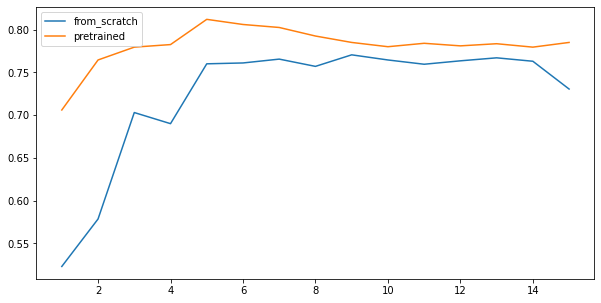

In [45]:
#Visualize the accuracy
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(range(1, epochs+1), from_scratch_valid_acc, label="from_scratch")
plt.plot(range(1, epochs+1), pretrained_valid_acc, label="pretrained")
plt.legend()